## 1. Imports

In [2]:
import os
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from random import sample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(f'Tensorflow version {tf.version.VERSION}')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Tensorflow version 2.7.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Read Data

In [9]:
# 1.6 mil tweets but only positive or negative
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.columns = ['emotion', 'id', 'timestamp', 'query', 'username', 'tweet']
df.drop(['id', 'query', 'username'],axis=1)
df_sample = df.sample(frac = 1)

df2 = pd.read_csv('data/sentimentData2.csv')
df2.columns = ['tweet', 'emotion']
df2 = df2.sample(frac = 1)
df2.head(10)

,tweet,emotion
19808,listening to muse like crazy till i see them\u...,2
73595,Sometimes I play the piano http://www.myspace...,2
14254,Celebrate the first day of classes with us tom...,2
12820,I will consider Arsenal to have the potential ...,2
249,I am gonna Meryl Streep the fuck out of this t...,1
25153,John Kasich may be the most genuine of all of ...,2
28622,@user yep\u002c wanted to limit it to 1 tweet!...,2
34171,"""Trump should let whoever comes in 11th place ...",1
28895,Here are the five Capital One Cup matches toni...,1
41351,"""1st Giroud, now Kane, lol what a funny day #T...",2


## 3. Tokenizer

In [17]:
dataframe = df2
fraction_df = 1
len_df = int(dataframe.shape[0])
vocab_size = int(1e6)
training_size = int(0.7 * len_df)
max_length = 50
trunc_type = 'post'

emos = dataframe['emotion'].to_numpy()
#emos = emos // 2
#timestamps = dataframe['timestamp'].to_numpy()
tweets = dataframe['tweet'].to_numpy()

train_sentences = tweets[0:training_size//fraction_df]
test_sentences = tweets[training_size//fraction_df:len_df//fraction_df]
train_emos = emos[0:training_size//fraction_df]
test_emos = emos[training_size//fraction_df:len_df//fraction_df]
train_emos = to_categorical(train_emos, 3)
test_emos = to_categorical(test_emos, 3)

#train_timestamp = timestamps[0:training_size//fraction_df]
#train_timestamp = timestamps[training_size//fraction_df:len_df//fraction_df]

tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post', truncating=trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post', truncating=trunc_type)

## 4. Model

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 64)            64000000  
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 64,074,499
Trainable params: 64,074,499
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 10
history = model.fit(train_padded, train_emos, epochs=num_epochs,
                    validation_data=(test_padded, test_emos), verbose=1)

Epoch 1/10
1705/1705 [==============================] - 72s 41ms/step - loss: 0.9446 - accuracy: 0.5264 - val_loss: 0.7997 - val_accuracy: 0.6303
Epoch 2/10
1705/1705 [==============================] - 69s 40ms/step - loss: 0.6972 - accuracy: 0.6957 - val_loss: 0.7752 - val_accuracy: 0.6433
Epoch 3/10
1705/1705 [==============================] - 69s 40ms/step - loss: 0.5775 - accuracy: 0.7604 - val_loss: 0.7548 - val_accuracy: 0.6623
Epoch 4/10
1705/1705 [==============================] - 67s 40ms/step - loss: 0.4837 - accuracy: 0.8060 - val_loss: 0.7878 - val_accuracy: 0.6583
Epoch 5/10
1705/1705 [==============================] - 67s 39ms/step - loss: 0.4066 - accuracy: 0.8435 - val_loss: 0.8691 - val_accuracy: 0.6531
Epoch 6/10
1705/1705 [==============================] - 67s 40ms/step - loss: 0.3476 - accuracy: 0.8684 - val_loss: 0.9364 - val_accuracy: 0.6459
Epoch 7/10
1705/1705 [==============================] - 68s 40ms/step - loss: 0.2957 - accuracy: 0.8906 - val_loss: 0.9927 -

## 5. Graphs

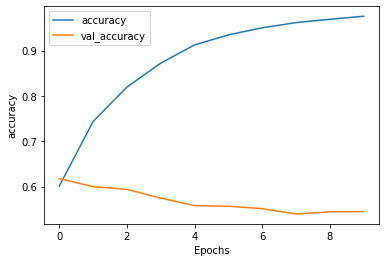

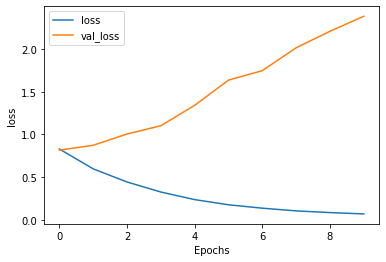

In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
predict_sentence = ['I fucking hate everything',
                    'I love you a lot',
                    'this is a sentence']

seq = tokenizer.texts_to_sequences(predict_sentence)
predict_padded = pad_sequences(seq, maxlen=max_length,
                               padding='post', truncating=trunc_type)

pred = model.predict(predict_padded)
print(pred)

[[0.9823025  0.04355055 0.07548778]
 [0.15416867 0.11521301 0.8919452 ]
 [0.27311805 0.26791736 0.79272896]]
